<bound method BaseSpectralCube.max of VaryingResolutionSpectralCube with shape=(1024, 1500, 1500) and unit=Jy / beam:
 n_x:   1500  type_x: RA---SIN  unit_x: deg    range:   290.914701 deg:  290.919002 deg
 n_y:   1500  type_y: DEC--SIN  unit_y: deg    range:    14.516089 deg:   14.520253 deg
 n_s:   1024  type_s: FREQ      unit_s: Hz     range: 42804687564.320 Hz:42820672254.215 Hz> Cube Max)
Jy / beam Unit Flux


/home/dealderod/.local/lib/python3.8/site-packages/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        500.0 290.9170756769094 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D


ValueError: Input must be 1- or 2-d.

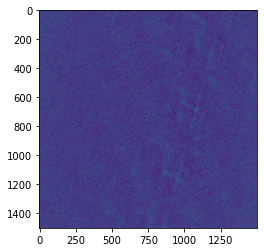

In [10]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

#Accessing Cube Data
cube = SpectralCube.read('/home/dealderod/derod/W51North_spw_39_Qband_rough_01.image.fits')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5

# maser_channel = 579

x, y = 144, 215
size = 4000
cube.allow_huge_operations=True
cube1 = cube[21,:,:]

max_2d_cube = cube.max(axis=0)
cube_cutout = max_2d_cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()

p_init_gauss2D = models.Gaussian2D(x_mean=290.9170756769094 * u.deg, y_mean=14.518231385948818 * u.deg, amplitude=500 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


# print("\n param_cov")

# print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)





print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (7,7)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

# plt.subplot(1, 3, 2)
# plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
#         " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
#         " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
#         style='italic',
#         bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
#         horizontalalignment='left')

# plt.tight_layout()
plt.show()